# Ripple NRTidalv2 verification notebook

In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from ripplegw import ms_to_Mc_eta, Mc_eta_to_ms, lambdas_to_lambda_tildes, get_eff_pads, get_match_arr
from ripplegw.waveforms import IMRPhenomD_NRTidalv2
import lalsimulation as lalsim
import lal

params = {"axes.grid": True,
        "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# m1 = 1.5
# m2 = 1.4
# chi1 = 0.0
# chi2 = 0.0
# lambda1 = 500
# lambda2 = 400
# distance = 40.0

Mc = 1.184844662
eta = 0.248789061

m1, m2 = Mc_eta_to_ms(jnp.array([Mc, eta]))

chi1 = 0.0
chi2 = 0.0
lambda1 = 600.0
lambda2 = 1000.0
distance = 1000.0

tc = 0.0
phic = 0.0
iota = 0.5
ra = 3.45
dec = -0.39
psi = 0.0

Get the frequency grid:

In [36]:
# Frequency grid
T = 8
f_l = 20.0
f_sampling = 2 * 2048
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [37]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
# tc = 0
# phic = 0
dist_mpc = distance
# inclination = 0
# polarization_angle = 0.0
inclination = iota
polarization_angle = psi

# Convert from source values to sample values
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(
    jnp.array([lambda1, lambda2, m1, m2])
)

theta_ripple = jnp.array(
    [
        Mc,
        eta,
        chi1,
        chi2,
        lambda_tilde,
        delta_lambda_tilde,
        dist_mpc,
        tc,
        phic,
        inclination,
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD_NRTidalv2.gen_IMRPhenomD_NRTidalv2_hphc(
    fs_ripple, theta_ripple, f_ref
)

## LAL

In [38]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
# print(quad1)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# print(oct1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)

IMRphenom = "IMRPhenomD_NRTidalv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/psds/psd.txt", unpack=True)

theta = np.array(
    [m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination]
)

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

In [39]:
hp_lalsuite

array([ 1.70354730e-24-1.66229594e-24j, -1.99518873e-24+1.26605801e-24j,
       -1.82104691e-24-1.47902489e-24j, ...,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j])

## Comparison

In [40]:
# One frequency variable, just f
f = freqs_lal[mask_lal]

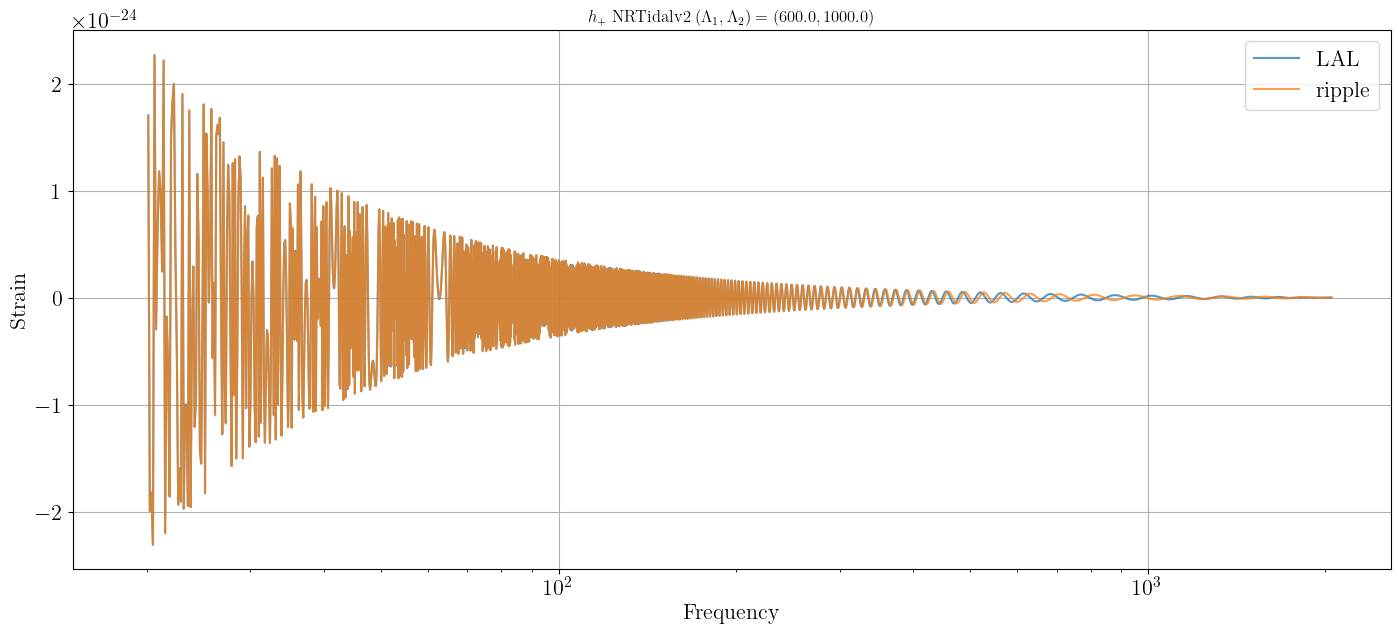

In [41]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label="LAL", alpha=a)
plt.plot(f, hp_ripple.real, "-", label="ripple", alpha=a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(
    r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2)
)
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.legend()
plt.show()

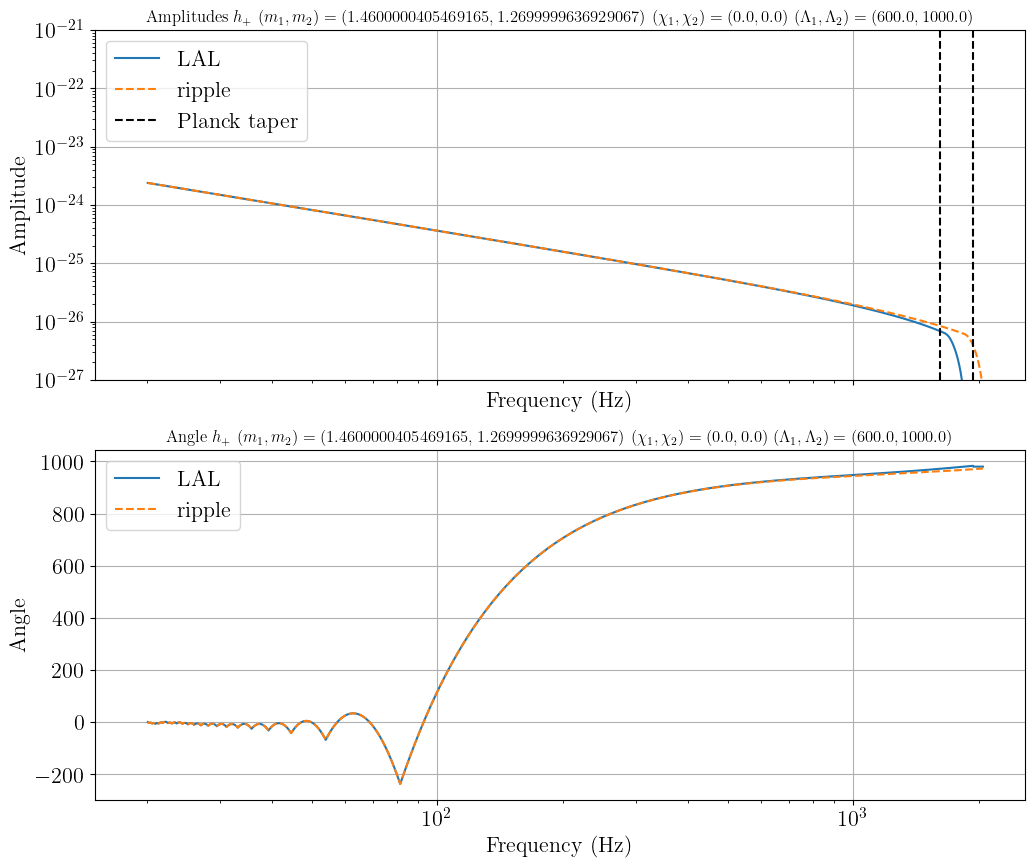

In [42]:
## Get the merger frequency to check the Planck taper window

l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])

f_merger = IMRPhenomD_NRTidalv2._get_merger_frequency(merger_params)
f_merger = float(f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label="LAL")
plt.plot(fs_ripple, A_ripple, "--", label="ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")

plt.title(
    r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label="ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label="ripple")
    name = "Phase"
plt.legend()
plt.title(
    r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.show()

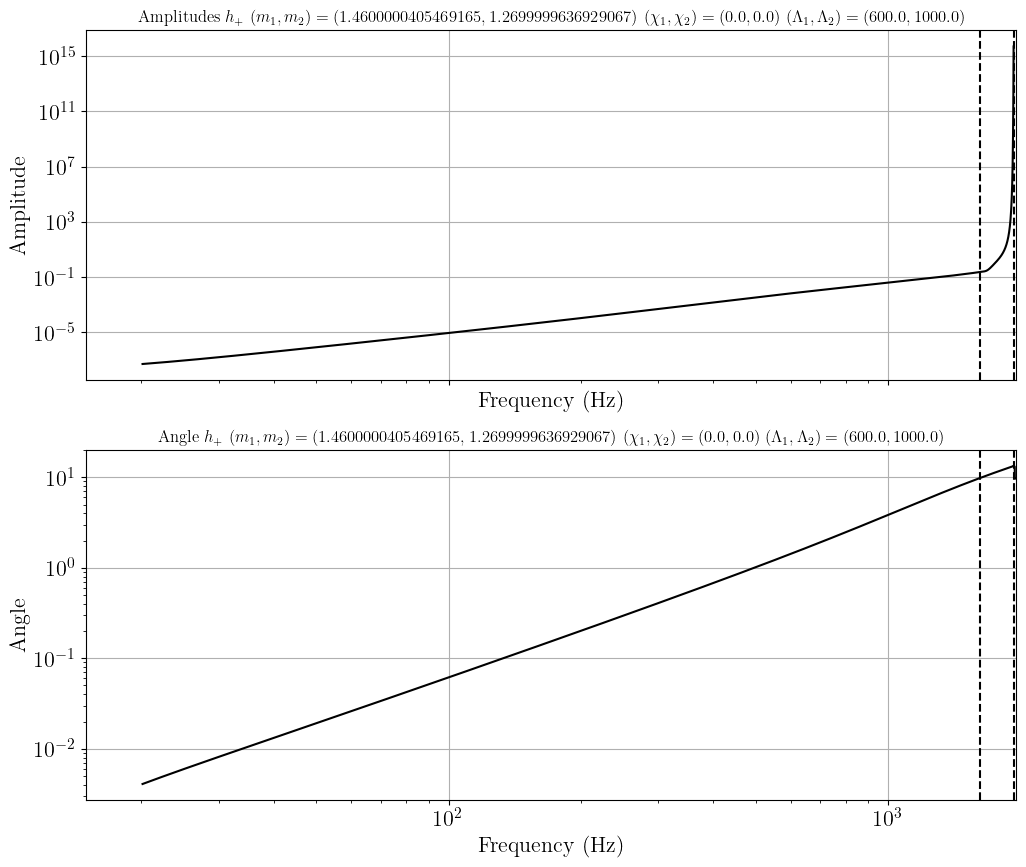

In [43]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple) / A_lalsuite
plt.plot(f, diffs_amplitude, "-", color="black")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")

plt.title(
    r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color="black")
name = "Angle"
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")
# plt.legend()
plt.title(
    r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale("log")
plt.show()

## Computing mismatch

In [44]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match = get_match_arr(
    pad_low,
    pad_high,
    # np.ones_like(fs) * 1.0e-42,
    PSD_vals,
    hp_ripple,
    hp_lalsuite,
)

print(f"Match: {match}")
print(f"Log 10 mismatch: {np.log10(1 - match)}")

Match: 0.9935269790428053
Log 10 mismatch: -2.188892986898448
